# 5 - Classification on a given dataset

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import optuna
from optuna.samplers import TPESampler

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold

### Loading the dataset

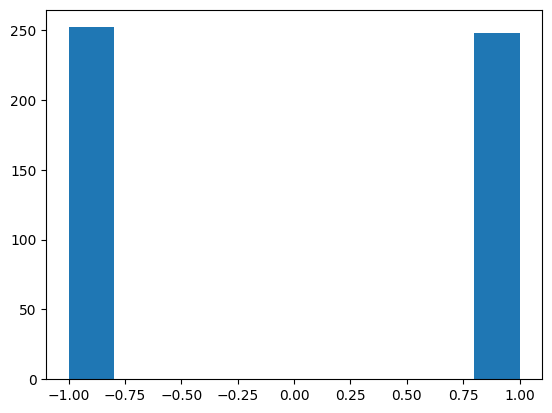

In [2]:
# Training - Load the raw data and the associated labels
X_train = np.load('./data/classification/X_train.npy')
y_train = np.load('./data/classification/y_train.npy')

# Testing - Similarly, the raw data and the associated labels
X_test = np.load('./data/classification/X_test.npy')
y_test = np.load('./data/classification/y_test.npy')

# Plot the distribution of the labels
plt.hist(y_train, bins=10)
plt.show()

## Classification

### Data preprocessing

In order to rescale our data in a certain range, we use the StandardScaler from sklearn.

In [3]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [4]:
!rm *.db

### Logistic Regression

In [5]:
def LogisticRegressionObjective(trial):
    # Parameters to be optimized for logistic regression classifier
    penalty = trial.suggest_categorical('penalty', ['l2'])
    C = trial.suggest_float('C', 1e-4, 1e-3)
    max_iter = trial.suggest_int('max_iter', 100, 500)
    random_state = trial.suggest_int('random_state', 0, 42)

    # Create the model
    model = LogisticRegression(
        penalty=penalty,
        C=C,
        max_iter=max_iter,
        random_state=random_state
    )

    cv = KFold(n_splits=4)
    cross_val_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean()

    return cross_val_scores

# Create a study object and optimize the objective function
logistic_regression_study = optuna.create_study(storage="sqlite:///logistic_regression.db",
                            study_name="logistic_regression",
                            load_if_exists=False,
                            direction='maximize',
                            sampler=TPESampler(seed=42))

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Start the optimization
logistic_regression_study.optimize(LogisticRegressionObjective, n_trials=500, n_jobs=-1, show_progress_bar=True)

# Print the optimized parameter values
print(logistic_regression_study.best_params)

[I 2023-06-24 20:07:07,996] A new study created in RDB with name: logistic_regression


  0%|          | 0/500 [00:00<?, ?it/s]

{'C': 0.0009484470789001768, 'max_iter': 331, 'penalty': 'l2', 'random_state': 35}


In [6]:
logistic_regression = LogisticRegression(**logistic_regression_study.best_params)
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)

# Mean accuracy score
print(f'Accuracy - {accuracy_score(y_test, y_pred) * 100:.2f}%')

Accuracy - 87.00%


### Gradient Boosting Classifier

In [7]:
def GradientBoostingObjective(trial):
    # Parameters to be optimized for gradient boosting classifier
    learning_rate = trial.suggest_categorical('learning_rate', [0.01])
    max_depth = trial.suggest_int('max_depth', 16, 32)
    subsample = trial.suggest_float('subsample', 0.5, 1.0, step=0.1)
    min_samples_split = trial.suggest_categorical('min_samples_split', [32])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [10])
    max_features = trial.suggest_categorical('max_features', ['log2'])
    random_state = trial.suggest_categorical('random_state', [10])

    # Create the model
    model = GradientBoostingClassifier(
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=random_state
    )

    # Train the model
    model.fit(X_train, y_train)

    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    cross_val_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=5).mean()
    return cross_val_scores

# Create a study object and optimize the objective function
gradient_boosting_study = optuna.create_study(storage="sqlite:///gradient_boosting.db",
                            study_name="gradient_boosting",
                            load_if_exists=False,
                            direction='maximize',
                            sampler=TPESampler(seed=42))

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Start the optimization
gradient_boosting_study.optimize(GradientBoostingObjective, n_trials=500, n_jobs=10, show_progress_bar=True)

# Print the optimized parameter values
print(gradient_boosting_study.best_params)

  0%|          | 0/500 [00:00<?, ?it/s]

{'learning_rate': 0.01, 'max_depth': 24, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 32, 'random_state': 10, 'subsample': 1.0}


In [8]:
test_params = {
    'learning_rate': 0.01,
    'max_depth': 32,
    'max_features': 'log2',
    'min_samples_leaf': 10,
    'min_samples_split': 32,
    'random_state': 10,
    'subsample': 1.0,
    'random_state': 10
}

gradient_boosting = GradientBoostingClassifier(**gradient_boosting_study.best_params)
gradient_boosting.fit(X_train, y_train)
y_pred = gradient_boosting.predict(X_test)

# Mean accuracy score
print(f'Accuracy - {accuracy_score(y_test, y_pred) * 100:.2f}%')

Accuracy - 86.40%


### Support Vector Classifier

In [9]:
def SVCObjective(trial):
    # Parameters to be optimized for SVC classifier
    C = trial.suggest_categorical('C', [1e-3])
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 2, 5)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    random_state = trial.suggest_int('random_state', 40, 50)

    # Create the model
    model = SVC(
        C=C,
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        random_state=random_state
    )

    cv = KFold(n_splits=4, shuffle=True, random_state=random_state)

    cross_val_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean()
    return cross_val_scores

# Create a study object and optimize the objective function
svc_study = optuna.create_study(storage="sqlite:///svc.db",
                            study_name="svc",
                            load_if_exists=False,
                            direction='maximize',
                            sampler=TPESampler(seed=42))

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Start the optimization
svc_study.optimize(SVCObjective, n_trials=1000, n_jobs=5, show_progress_bar=True)

# Print the optimized parameter values
print(svc_study.best_params)
print(svc_study.best_value)

  0%|          | 0/1000 [00:00<?, ?it/s]

{'C': 0.001, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'random_state': 41}
0.736


In [10]:
svc = SVC(**svc_study.best_params)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

# Mean accuracy score
print(f'Accuracy - {accuracy_score(y_test, y_pred) * 100:.2f}%')

Accuracy - 87.40%


### Random Forest Classifier

In [11]:
def RandomForestObjective(trial):
    # Parameters to be optimized for random forest classifier
    n_estimators = trial.suggest_int('n_estimators', 200, 800, step=100)
    max_depth = trial.suggest_int('max_depth', 16, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [10])
    max_features = trial.suggest_categorical('max_features', ['log2'])
    random_state = trial.suggest_categorical('random_state', [50])

    # Create the model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,  
        random_state=random_state
    )

    # Cross-validation
    kf = KFold(n_splits=4, shuffle=True, random_state=random_state)

    # Obtain the cross-validation accuracy for this set of parameters
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy', n_jobs=10)
    return scores.mean()

# Create a study object and optimize the objective function
random_forest_study = optuna.create_study(storage="sqlite:///randomforest.db",
                            study_name="random_forest",
                            load_if_exists=False,
                            direction='maximize',
                            sampler=TPESampler(seed=10))

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Start the optimization
random_forest_study.optimize(RandomForestObjective, n_trials=200, n_jobs=10, show_progress_bar=True)

# Print the optimized parameter values
print(random_forest_study.best_params)

  0%|          | 0/200 [00:00<?, ?it/s]

{'max_depth': 19, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 9, 'n_estimators': 300, 'random_state': 50}


In [12]:
random_forest = RandomForestClassifier(**random_forest_study.best_params)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

# Mean accuracy score
print(f'Accuracy - {accuracy_score(y_test, y_pred) * 100:.2f}%')

Accuracy - 87.00%


### KNeighbors Classifier

In [13]:
def KNNObjective(trial):
    # Parameters to be optimized for KNN classifier
    n_neighbors = trial.suggest_int('n_neighbors', 170, 180, step=1)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    # algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    leaf_size = trial.suggest_int('leaf_size', 5, 10)
    p = trial.suggest_categorical('p', [1])

    # Create the model
    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        # algorithm=algorithm,
        leaf_size=leaf_size,
        p=p
    )

    model.fit(X_train, y_train)

    cv = KFold(n_splits=4, shuffle=True, random_state=123)

    cross_val_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean()
    return cross_val_scores

# Create a study object and optimize the objective function
knn_study = optuna.create_study(storage="sqlite:///knn.db",
                            study_name="knn",
                            load_if_exists=False,
                            direction='maximize',
                            sampler=TPESampler(seed=10))

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Start the optimization
knn_study.optimize(KNNObjective, n_trials=500, n_jobs=5, show_progress_bar=True)

# Print the optimized parameter values
print(knn_study.best_params)

  0%|          | 0/500 [00:00<?, ?it/s]

{'leaf_size': 7, 'n_neighbors': 178, 'p': 1, 'weights': 'distance'}


In [14]:
knn = KNeighborsClassifier(**knn_study.best_params)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Mean accuracy score
print(f'Accuracy - {accuracy_score(y_test, y_pred) * 100:.2f}%')

Accuracy - 85.80%
